# Demo of AOMA on Hålogaland bridge

In [2]:
import numpy as np
import dataloader_halogaland.dataloader as dl
import dataloader_halogaland.processer as pr
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
import datetime
import koma.oma, koma.plot
import koma.clustering

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
loader = dl.Dataloader(os.getcwd()+'/../Data/Halogaland_2022_04_22')
file = loader.read_file(loader.anodes[0])
acc = loader.load_acceleration(loader.acc_names[0], file)




In [4]:
time = acc['timestamp']
dt = time[1]- time[0]
sampling_frequency =1/dt
downsampled_time, downsampled_acc_1x = pr.downsample(time, acc['1y'], sampling_frequency_new=2)
print(sampling_frequency)

64.0


In [5]:
print(np.shape(acc['1y'])[0])

1843200


### Load and preprocess acceleration data from all sensors on bridge deck

In [6]:
acc_x_all = np.zeros([np.shape(downsampled_acc_1x)[0], np.shape((loader.anodes))[0]*2]) #np.zeros(len(loader.anodes))
acc_y_all = np.zeros([np.shape(downsampled_acc_1x)[0], np.shape((loader.anodes))[0]*2])
acc_z_all = np.zeros([np.shape(downsampled_acc_1x)[0], np.shape((loader.anodes))[0]*2])
time_all = [] #np.zeros(len(loader.anodes))

for i in range(len(loader.anodes)):

    file = loader.read_file(loader.anodes[i])
    acc = loader.load_acceleration(loader.acc_names[i], file)

    time = acc['timestamp']
    acc_1x = acc['1x']
    acc_2x = acc['2x']
    acc_1y = acc['1y']
    acc_2y = acc['2y']
    acc_1z = acc['1z']
    acc_2z = acc['2z']

    #Low pass
    filtered_acc_1x = pr.low_pass(acc_1x, sampling_frequency, cutoff_frequency=2, filter_order=10)
    filtered_acc_2x = pr.low_pass(acc_2x, sampling_frequency, cutoff_frequency=2, filter_order=10)
    filtered_acc_1z = pr.low_pass(acc_1y, sampling_frequency, cutoff_frequency=2, filter_order=10)
    filtered_acc_2z = pr.low_pass(acc_2y, sampling_frequency, cutoff_frequency=2, filter_order=10)
    filtered_acc_1y = pr.low_pass(acc_1z, sampling_frequency, cutoff_frequency=2, filter_order=10)
    filtered_acc_2y = pr.low_pass(acc_2z, sampling_frequency, cutoff_frequency=2, filter_order=10)

    #Downsample
    downsampled_time, downsampled_acc_1x = pr.downsample(time, filtered_acc_1x, sampling_frequency_new=2)
    _ , downsampled_acc_2x = pr.downsample(time, filtered_acc_2x, sampling_frequency_new=2)
    _ , downsampled_acc_1y = pr.downsample(time, filtered_acc_1y, sampling_frequency_new=2)
    _ , downsampled_acc_2y = pr.downsample(time, filtered_acc_2y, sampling_frequency_new=2)
    _ , downsampled_acc_1z = pr.downsample(time, filtered_acc_1z, sampling_frequency_new=2)
    _ , downsampled_acc_2z = pr.downsample(time, filtered_acc_2z, sampling_frequency_new=2)

    acc_x_all[:, i] = downsampled_acc_1x; acc_x_all[:, i+8] = downsampled_acc_2x
    acc_y_all[:, i] = downsampled_acc_1y; acc_y_all[:, i+8] = downsampled_acc_2y
    acc_z_all[:, i] = downsampled_acc_1z; acc_z_all[:, i+8] = downsampled_acc_2z

acc_all = np.concatenate((acc_x_all, acc_y_all, acc_z_all), axis=1)
#time_all = np.array(time_all).transpose()


In [7]:
print(acc_all.shape)
#print(time_all[:][:2400].shape)

(57600, 48)


In [8]:
acc_all = acc_all[:][:2400]
print(acc_all.shape)

(2400, 48)


In [9]:
i = 24
s = 6
fs = 2
orders = np.arange(2, 250+2, 2)

stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

In [10]:
#Cov-SSI call
lambd, phi = koma.oma.covssi(acc_all, fs, i, orders, showinfo=True) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

print(lambd_stab.shape)
print(phi_stab.shape)

#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi


*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed
(494,)
(48, 494)


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


In [31]:
print(len(omega_n_auto))
print(len(phi_auto[1]))
print(len(phi_auto[2]))
print(len(phi_auto[3]))
print(len(phi_auto[4]))
print(len(phi_auto[5]))
print(len(phi_auto[6]))
print(len(phi_auto[7]))
print(len(phi_auto[8]))
print(len(phi_auto[9]))
print(len(phi_auto[10]))



12
48
48
48
48
48
48
48
48
48
48


In [11]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.146789,3.171976
1,0.212989,3.183896
2,0.354708,0.478596
3,0.357207,0.884202
4,0.445123,1.030700
5,0.449443,0.298938
6,0.449445,0.291001
7,0.617957,0.219226
8,0.624336,0.287581
9,0.635767,0.865101


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_17155/2048735216.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, lambd= lambd_stab, all_orders= orders_stab)


<Figure size 1200x640 with 0 Axes>

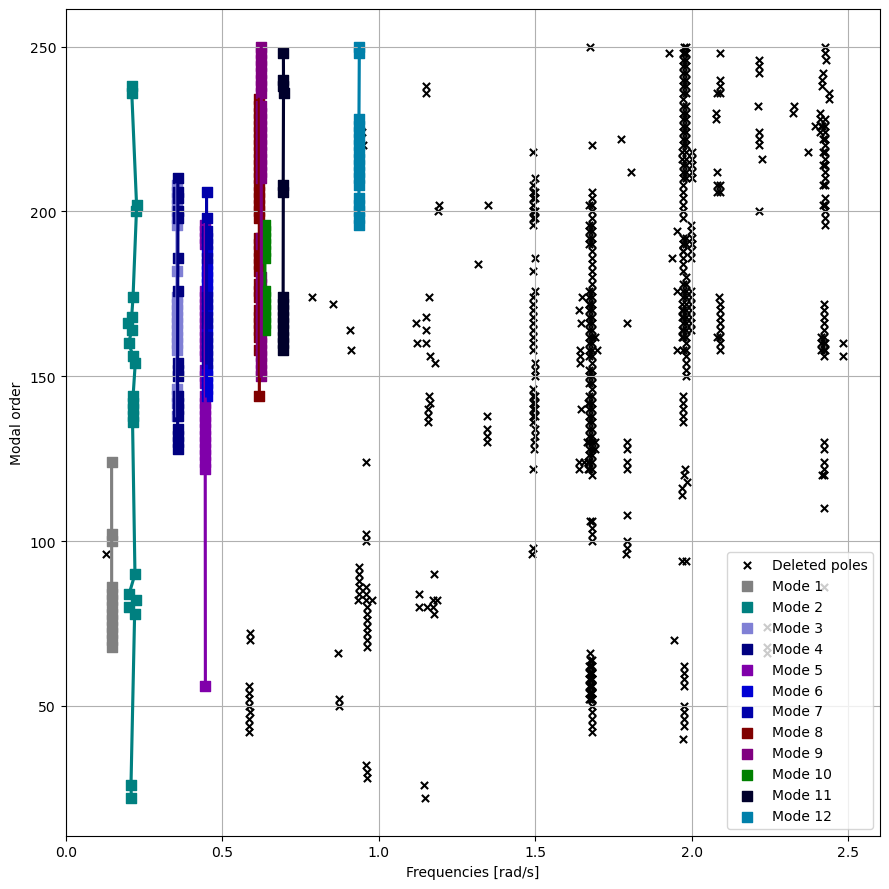

In [11]:
import plot_koma
plt.figure(figsize=(15, 8), dpi=80)
fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, lambd= lambd_stab, all_orders= orders_stab)
plt.grid()
plt.savefig("hålogaland_first_AOMA.jpg")

In [32]:
from python_appendix import OMA_functions as OMA

# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only

print(len(grouped_phis))

phi_extracted = np.zeros((len(grouped_phis), 48))
print(phi_extracted.shape)

for i in range(len(grouped_phis)):
    #print(len(grouped_phis[i]))
    #print(type(grouped_phis[i]))
    for j in range(np.shape(grouped_phis[i])[0]):
       phi_extracted[i,j] = (np.real(np.mean(grouped_phis[i][j])))

phi_extracted = phi_extracted.transpose()

12
(12, 48)


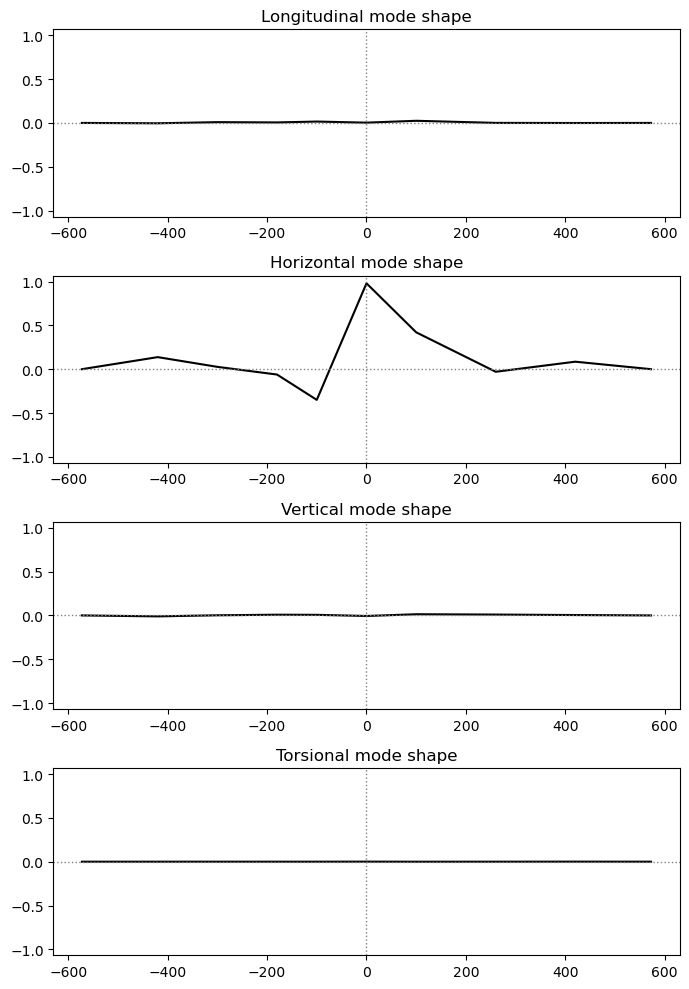

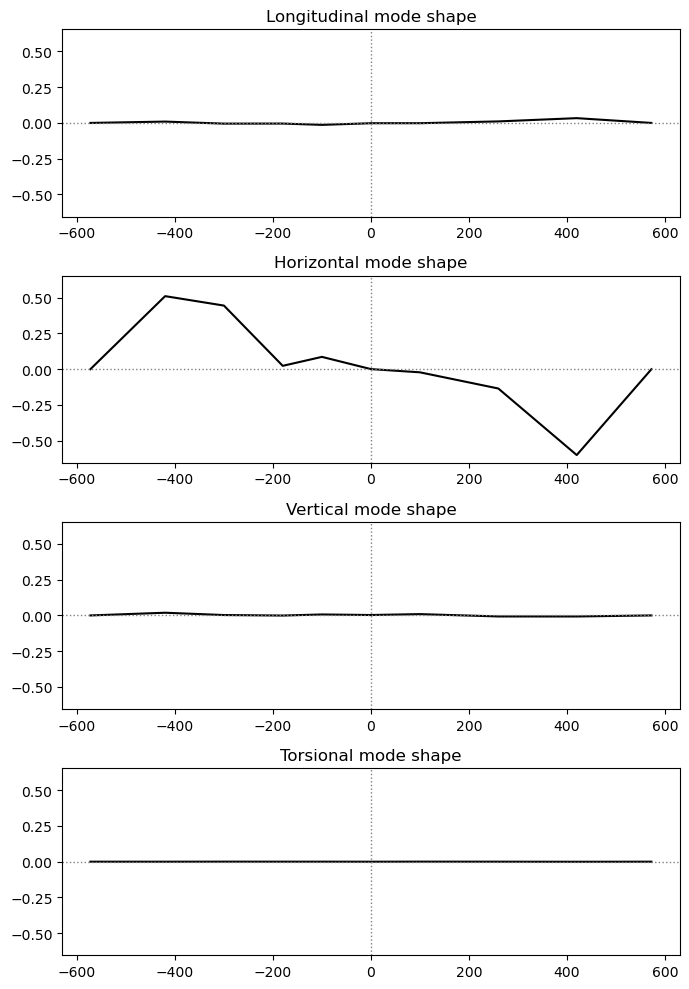

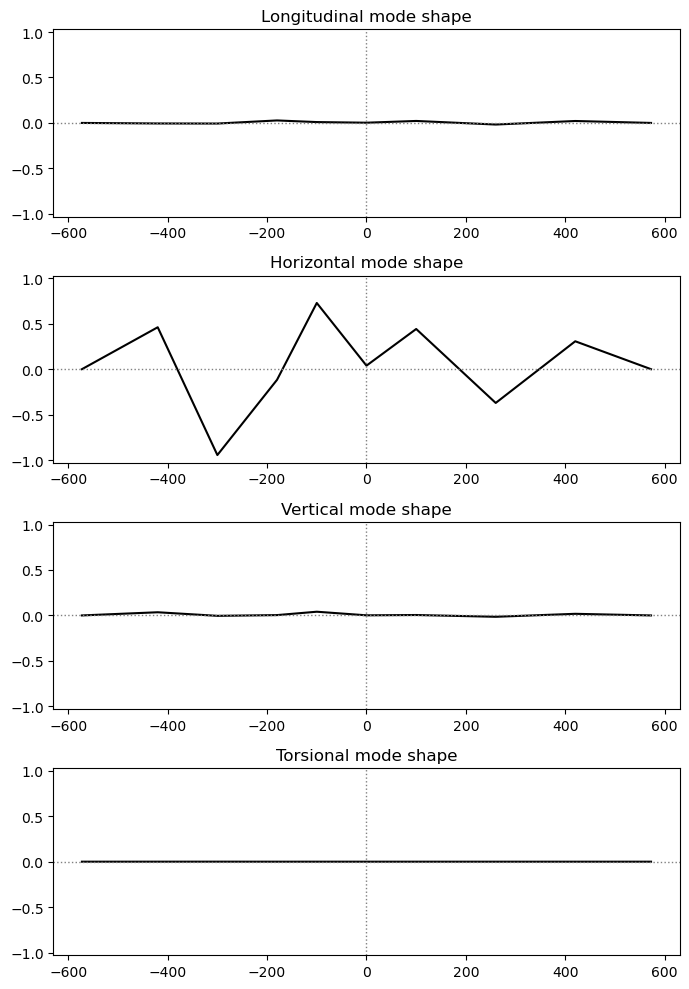

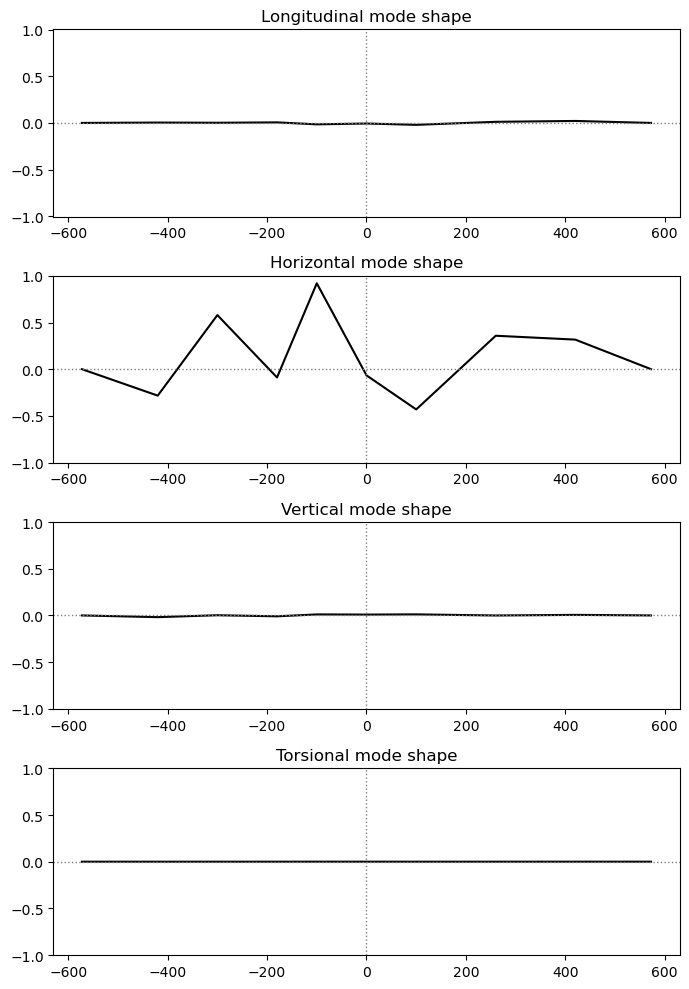

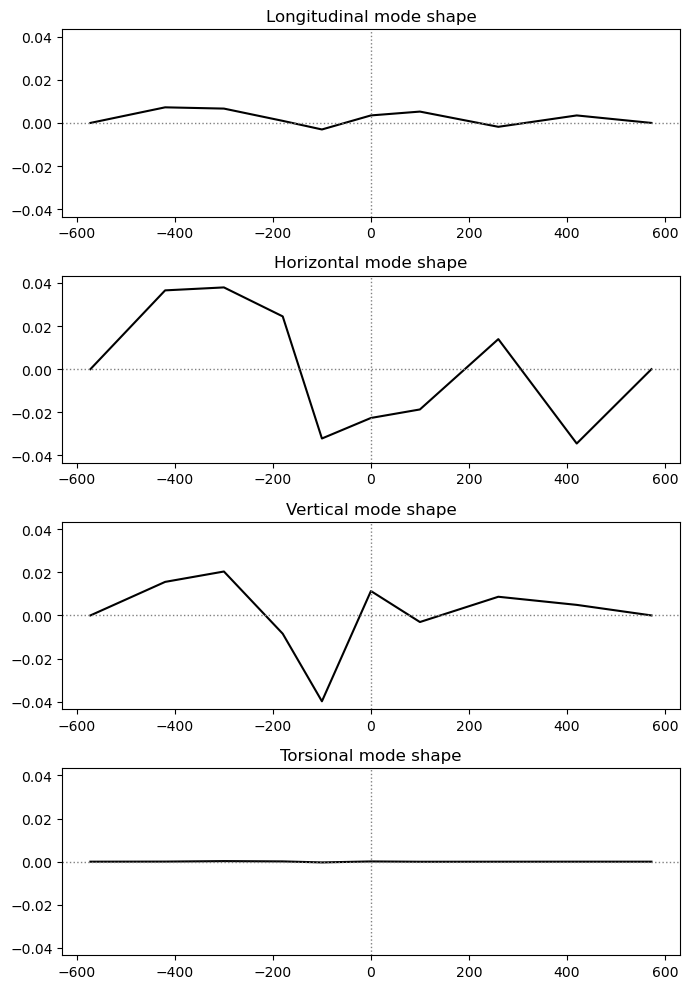

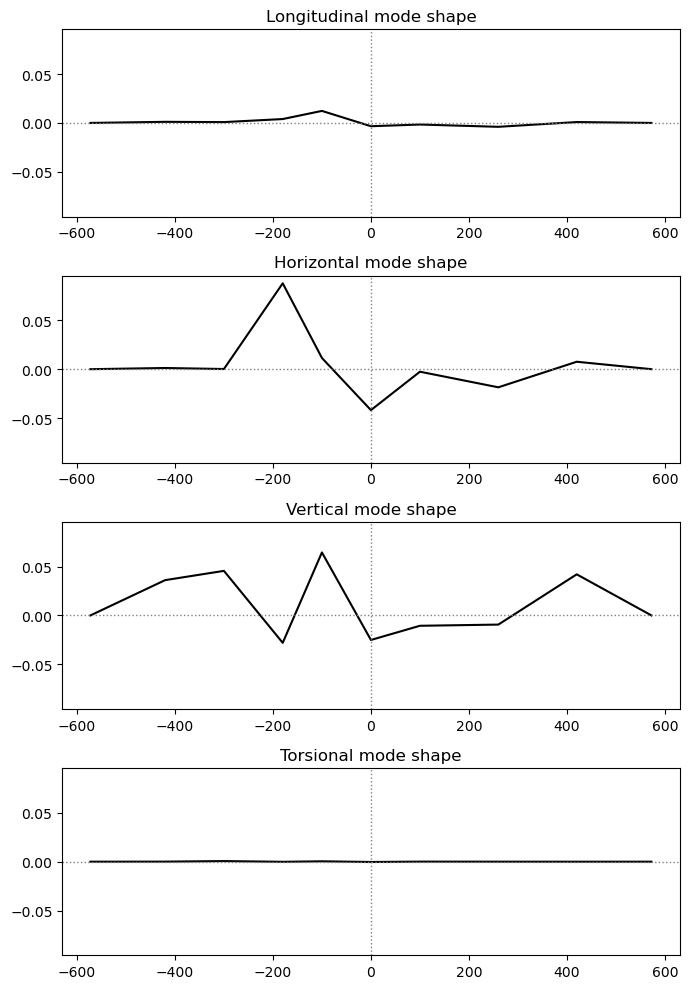

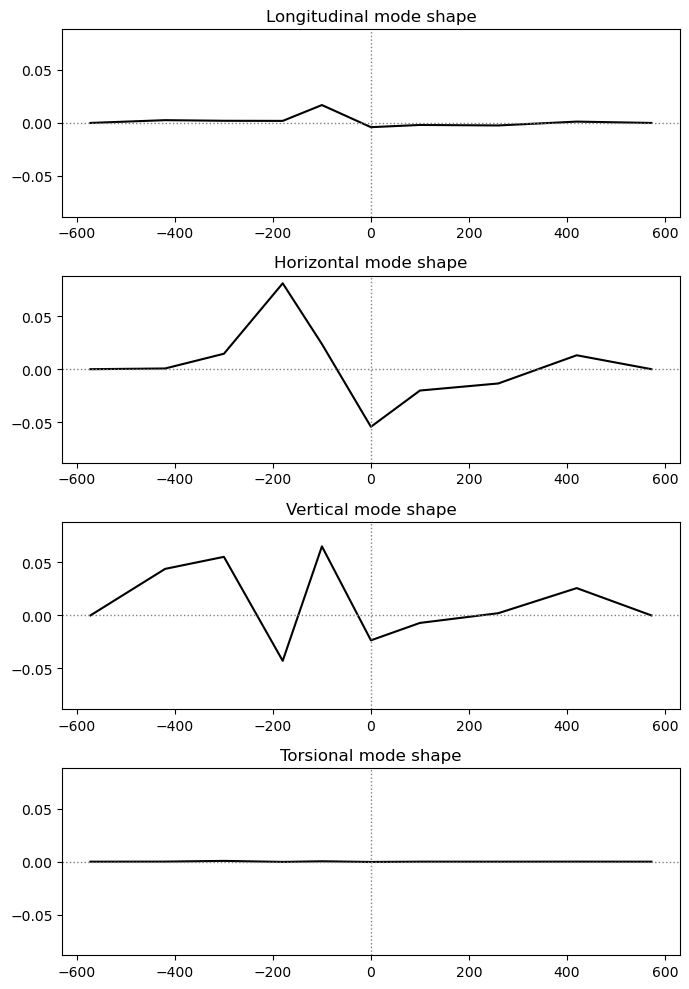

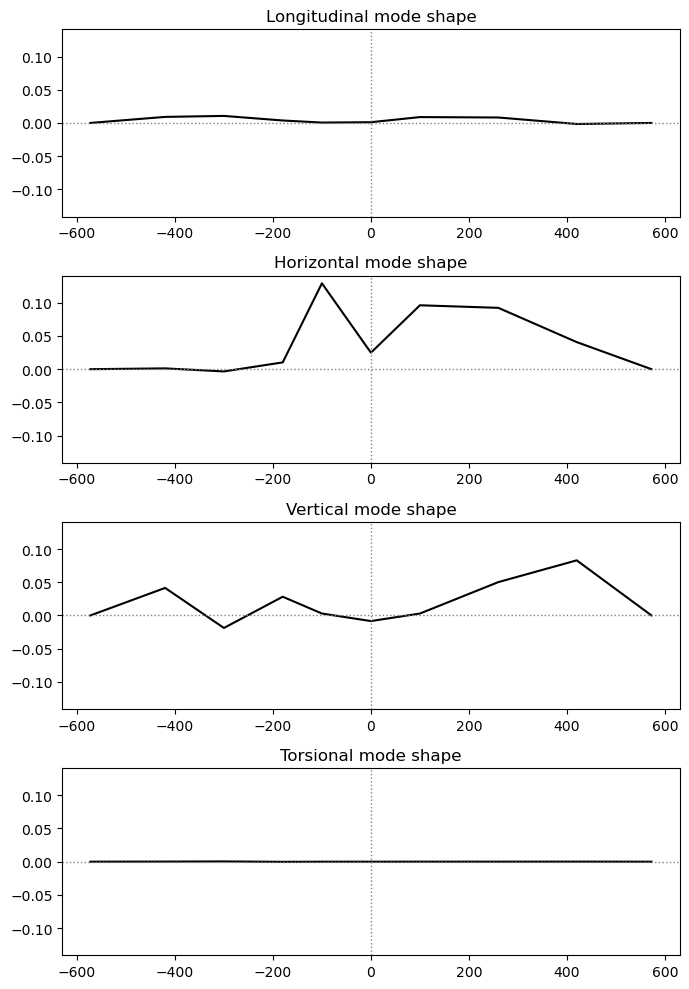

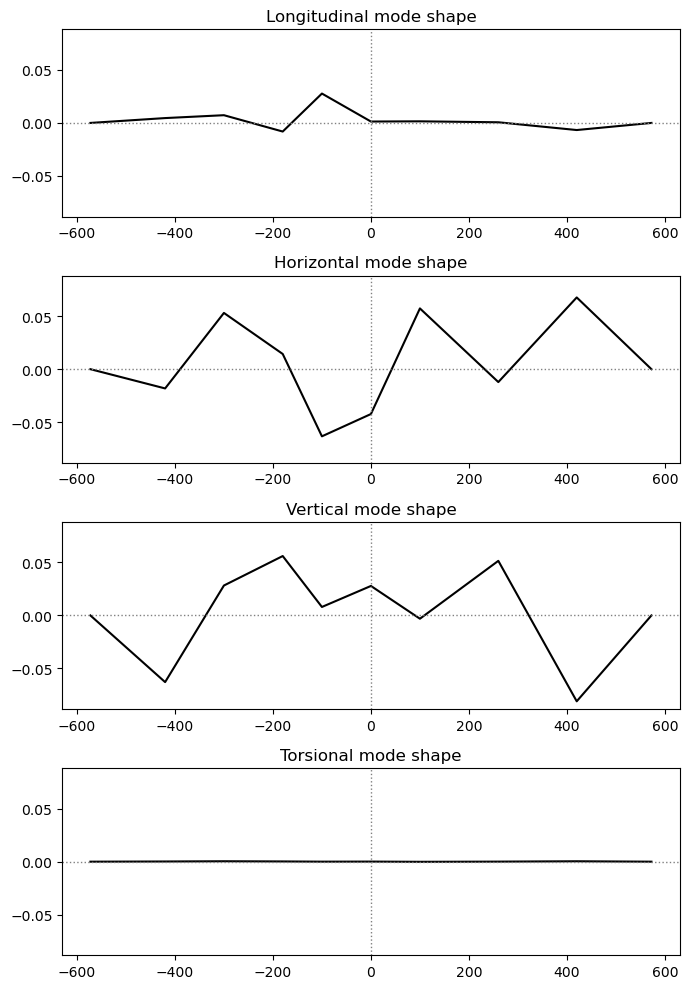

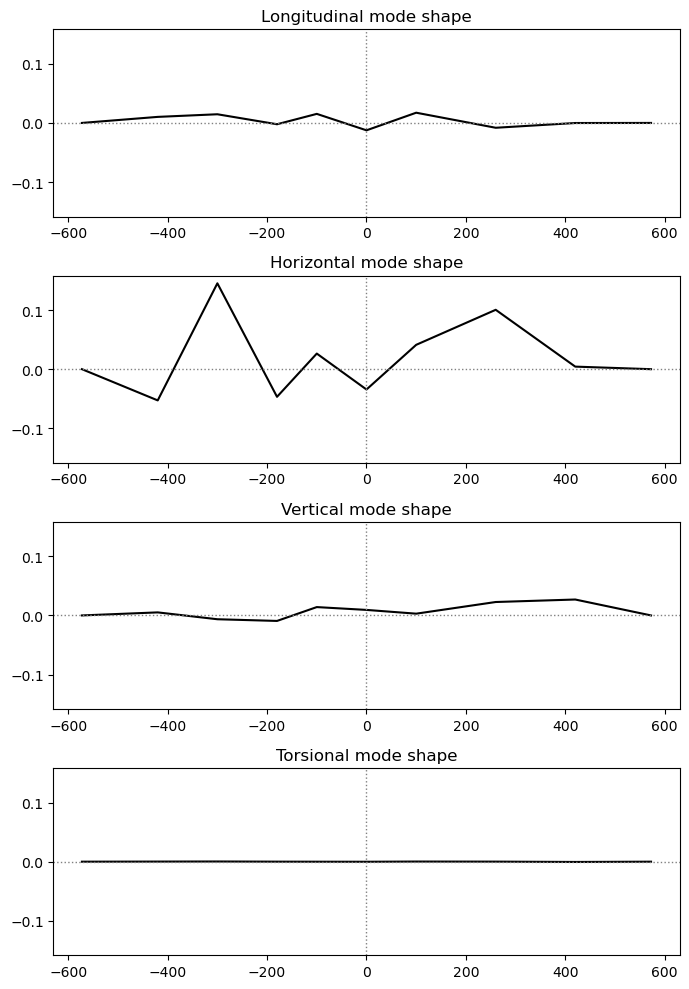

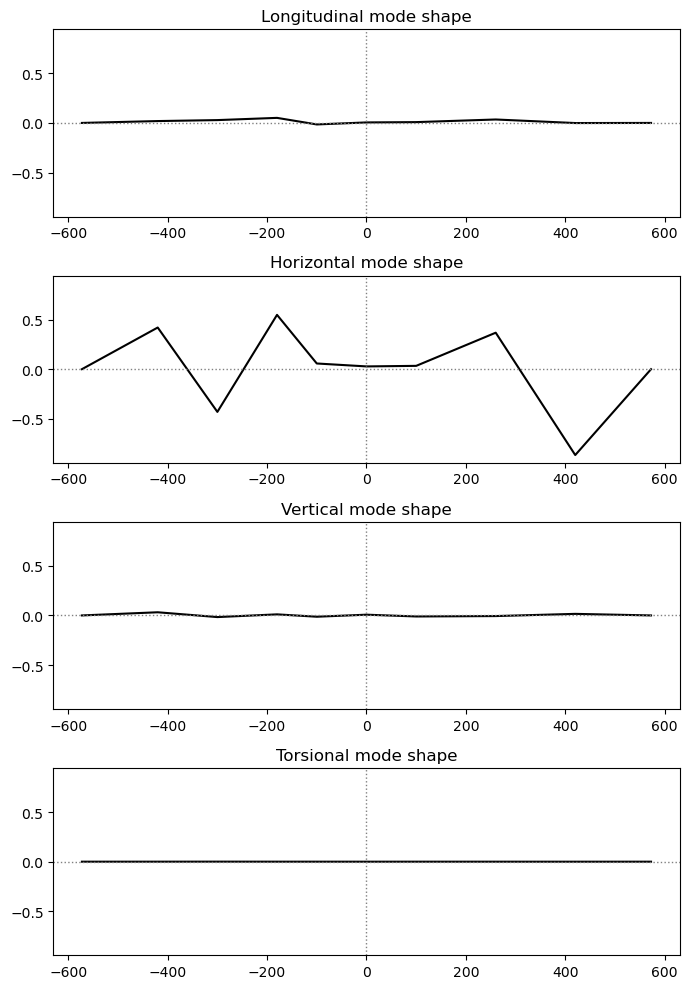

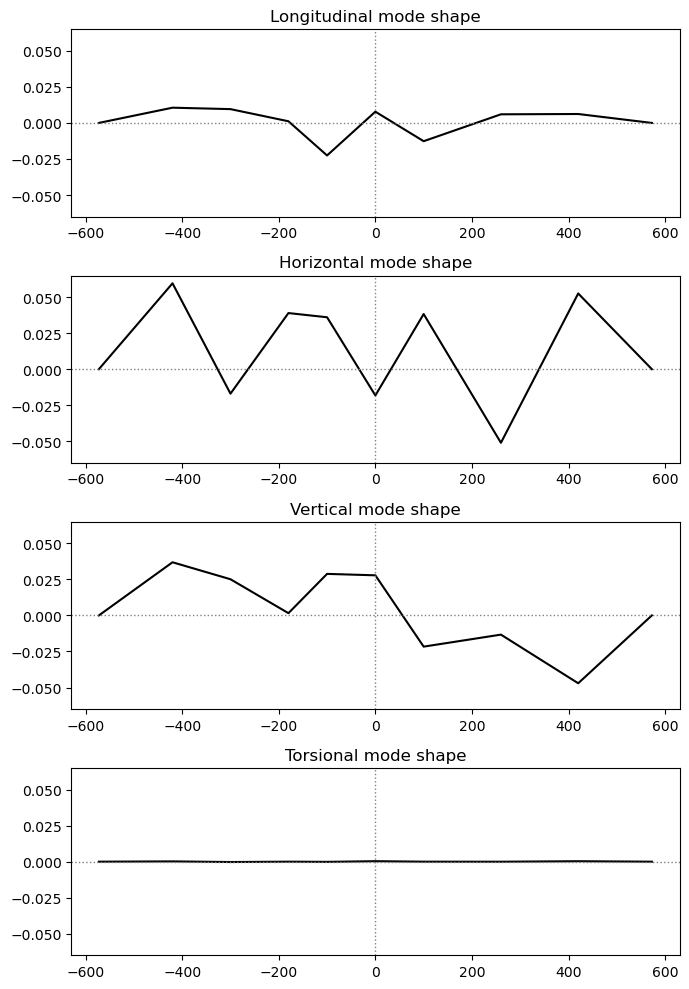

In [33]:

for i in range(phi_extracted.shape[1]):
    fig_shape = OMA.plotModeShape(phi_extracted, i)
    plt.savefig("plots/emil/modeshape_mode_" + str(i+1) + ".jpg")

In [14]:
from python_appendix import OMA_functions as OMA

fig_shape = OMA.plotModeShape(grouped_phis, 1)


TypeError: list indices must be integers or slices, not tuple